<a href="https://colab.research.google.com/github/hpink97/tensorflow_keras_practice/blob/main/SP500_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TO-DO list;


*   Change target variable to percentage change instead of actual stock value
*   X sequence will be daily percentage changes
*   Y will be total percentage change in n_future period (e.g. 30 days)
*   **Seperate scalers for daily perc_change and 30d perc_change**
*   Will enable entire history to be used without being affected by low values



In [24]:
#!pip install datapackage
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import math

from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
import xgboost as xgb



In [25]:
data1 = pd.read_csv('https://raw.githubusercontent.com/hpink97/tensorflow_keras_practice/main/sp500_1927_2020.csv')
data1.Date = pd.to_datetime(data1.Date)
data1 = data1[data1.Date >='1995-01-01']

data1.head()

,Date,Open,High,Low,Close,Adj Close,Volume
16815,1995-01-03,459.209991,459.269989,457.200012,459.109985,459.109985,262450000
16816,1995-01-04,459.130005,460.720001,457.559998,460.709991,460.709991,319510000
16817,1995-01-05,460.730011,461.299988,459.750000,460.339996,460.339996,309050000
16818,1995-01-06,460.380005,462.489990,459.470001,460.679993,460.679993,308070000
16819,1995-01-09,460.670013,461.769989,459.739990,460.829987,460.829987,278790000


In [26]:
data2 = pd.read_csv('https://raw.githubusercontent.com/hpink97/tensorflow_keras_practice/main/sp500_2012_2022.csv')
data2.Date = pd.to_datetime(data2.Date)

data2 = data2[data2.Date > data1.Date.max()]
data2 = data2.sort_values('Date').rename(columns={'Close/Last':'Close'})

data2.head()

,Date,Close,Volume,Open,High,Low
539,2020-11-05,3510.45,--,3485.74,3529.05,3485.74
538,2020-11-06,3509.44,--,3508.34,3521.58,3484.34
537,2020-11-09,3550.50,--,3583.04,3645.99,3547.48
536,2020-11-10,3545.53,--,3543.26,3557.22,3511.91
535,2020-11-11,3572.66,--,3563.22,3581.16,3557.00


In [27]:
data_array = [data1[['Date','Close']], data2[['Date','Close']]]

df = pd.concat(data_array, ignore_index=True, sort=False)
##fill in missing days
df = df.set_index('Date').resample('1D').mean().bfill()
df['rolling_mean'] = df.Close
df['Date'] = df.index
df = df.dropna()


df[df.rolling_mean <500]


,Close,rolling_mean,Date
Date,,,
1995-01-03,459.109985,459.109985,1995-01-03
1995-01-04,460.709991,460.709991,1995-01-04
1995-01-05,460.339996,460.339996,1995-01-05
1995-01-06,460.679993,460.679993,1995-01-06
1995-01-07,460.829987,460.829987,1995-01-07
...,...,...,...
1995-03-19,496.140015,496.140015,1995-03-19
1995-03-20,496.140015,496.140015,1995-03-20
1995-03-21,495.070007,495.070007,1995-03-21


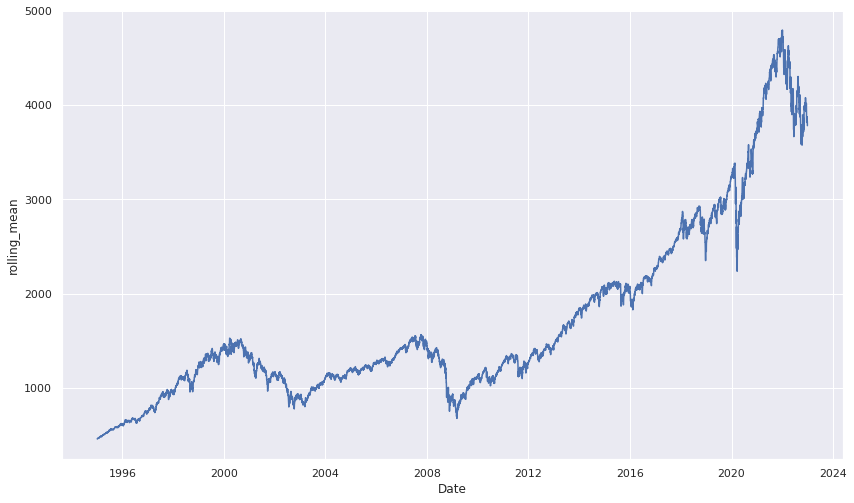

In [28]:
sns.set(rc={'figure.figsize':(14.0,8.27)})
sns.lineplot(data=df, x="Date", y="rolling_mean")

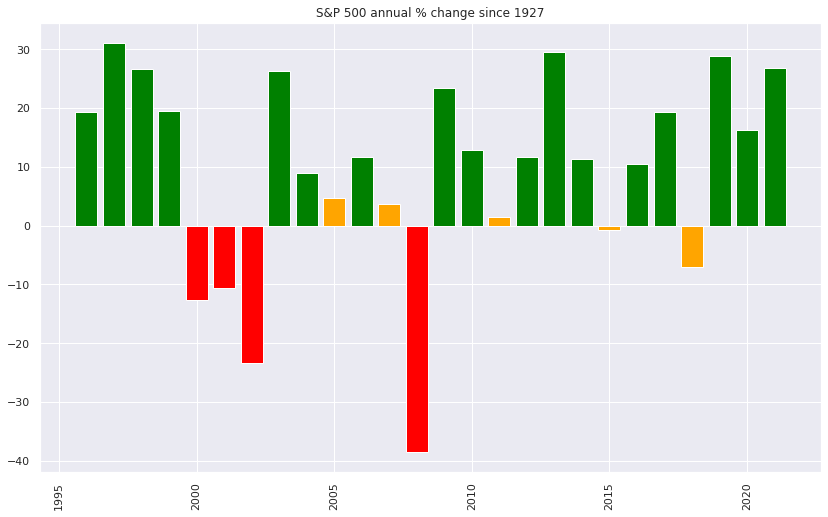

In [29]:
###calculate percentage change by year
pcnt_change = df.copy()
pcnt_change['year'] = df.Date.dt.year
pcnt_change['month'] = df.Date.dt.month
pcnt_change['day'] = df.Date.dt.day
pcnt_change = pcnt_change.loc[(pcnt_change.month ==12) &( pcnt_change.day ==31),['year','rolling_mean']]
pcnt_change['yr_pcnt_change'] = 100*pcnt_change['rolling_mean'].pct_change()
pcnt_change = pcnt_change.dropna()

x=pcnt_change.year
y=pcnt_change.yr_pcnt_change

profit_color = [{p< -10: 'red', -10<=p<=10: 'orange', p>8: 'green'}[True] for p in y]

plt.bar(x, y, color=profit_color)
plt.title('S&P 500 annual % change since 1927')
plt.xticks(rotation=90)
plt.show()

## Peform pre-processing of data for training

In [30]:
### convert to numpy array 7day rolling average 
df = df.dropna()
vals = df['rolling_mean'].values.reshape(-1, 1)
vals = vals.astype('float32') #COnvert values to float

vals[[0,69,5000,6500]]

array([[ 459.11],
       [ 490.05],
       [1249.05],
       [1433.82]], dtype=float32)

In [31]:
##scale all stock prices to values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
vals = scaler.fit_transform(vals)
vals[[0,69,5000,6500]]

array([[0.        ],
       [0.00713322],
       [0.18212083],
       [0.22471958]], dtype=float32)

In [32]:
##split into train-test split
train_size = int(len(vals) * 0.75)
validation_size = int(len(vals) * 0.88)
test_size = len(vals) - validation_size
train,validation, test = vals[0:train_size,:],vals[train_size:validation_size,:] ,vals[validation_size:len(vals),:]

print(f"S&P500 data has been into train ({len(train)} datapoints), validation ({len(validation)} datapoints) and test ({len(test)} datapoints). ")
print(f"Training data is from {df.Date[0]:%d/%m/%Y} until {df.Date[train_size-1]:%d/%m/%Y}")
print(f"Validation data is from  {df.Date[train_size]:%d/%m/%Y} until {df.Date[validation_size-1]:%d/%m/%Y}")
print(f"Testing data is from  {df.Date[validation_size]:%d/%m/%Y} until {df.Date[len(vals)-1]:%d/%m/%Y}")

##Test samples are after {df.Date[train_size]}"

S&P500 data has been into train (7666 datapoints), validation (1329 datapoints) and test (1227 datapoints). 
Training data is from 03/01/1995 until 29/12/2015
Validation data is from  30/12/2015 until 19/08/2019
Testing data is from  20/08/2019 until 28/12/2022


In [33]:
len(test)+len(train)+len(validation) == len(vals)

True

In [34]:
def to_sequences(dataset, n_past, n_future):
    x = []
    y = []

    for i in range(n_past, len(dataset) - n_future +1):
        #print(i)
        x.append(dataset[i - n_past:i,0])
        y.append(dataset[i + n_future - 1:i + n_future, 0])
        
    return np.array(x),np.array(y)



In [35]:
n_past = 182 ##16 weeks (approx 4mths) or previous data to train on
n_future = 60 ## predict 12 weeks into the future

trainX, trainY = to_sequences(train, n_past,n_future)
validX, validY = to_sequences(validation, n_past,n_future) 
testX, testY = to_sequences(test, n_past,n_future)

In [36]:
##reshape data for LSTM
trainX = np.reshape(trainX, (trainX.shape[0], 1, n_past))
validX = np.reshape(validX, (validX.shape[0], 1, n_past))
testX = np.reshape(testX, (testX.shape[0], 1, n_past))

print(f"S&P500 data has been into train ({len(trainX)} datapoints), validation ({len(validX)} datapoints) and test ({len(testX)} datapoints). ")


S&P500 data has been into train (7425 datapoints), validation (1088 datapoints) and test (986 datapoints). 


In [37]:
#print('Single LSTM with hidden Dense...')
model = Sequential()
model.add(LSTM(units = 300))#, return_sequences = True))
model.add(Dropout(0.15))
#model.add(LSTM(units = 50))
#model.add(Dropout(0.08))
model.add(Dense(24))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [38]:
es = EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=75, 
                       verbose=1, mode='min', restore_best_weights=True)

###fit to model 
history = model.fit(trainX, trainY, validation_data=(validX, validY),
          verbose=1, epochs=200, batch_size=256, callbacks=[es])

Epoch 1/200
30/30 [==============================] - 4s 51ms/step - loss: 0.0056 - val_loss: 0.0035
Epoch 2/200
30/30 [==============================] - 1s 31ms/step - loss: 8.1252e-04 - val_loss: 0.0034
Epoch 3/200
30/30 [==============================] - 1s 32ms/step - loss: 5.8789e-04 - val_loss: 0.0030
Epoch 4/200
30/30 [==============================] - 1s 32ms/step - loss: 5.3259e-04 - val_loss: 0.0019
Epoch 5/200
30/30 [==============================] - 1s 31ms/step - loss: 4.9847e-04 - val_loss: 0.0017
Epoch 6/200
30/30 [==============================] - 1s 32ms/step - loss: 4.4210e-04 - val_loss: 9.9045e-04
Epoch 7/200
30/30 [==============================] - 1s 32ms/step - loss: 4.2689e-04 - val_loss: 0.0017
Epoch 8/200
30/30 [==============================] - 1s 32ms/step - loss: 4.1255e-04 - val_loss: 0.0017
Epoch 9/200
30/30 [==============================] - 1s 33ms/step - loss: 4.0164e-04 - val_loss: 0.0019
Epoch 10/200
30/30 [==============================] - 1s 32ms/st

In [39]:
###use model to predict values for the validation set and testing set
## use our original scaler to reverse_transform to return to original values (USD)
trainPredict =  scaler.inverse_transform(model.predict(trainX).reshape(-1,1))
validationPredict =  scaler.inverse_transform(model.predict(validX).reshape(-1,1))
testPredict =  scaler.inverse_transform(model.predict(testX).reshape(-1,1))

31/31 [==============================] - 0s 4ms/step


In [40]:
## again inverse_transform to get real Y-values back to USD
trainY = scaler.inverse_transform(trainY.reshape(-1, 1))
validY = scaler.inverse_transform(validY.reshape(-1, 1))
testY = scaler.inverse_transform(testY.reshape(-1, 1))

## As a best guess, use current S&P500 price, as a predictor of the price in 14 days time...

-If we can beat this with our model, shows our prediction is better than just saying S&P500 price will be the same in 2 weeks

In [41]:
def get_last_X_from_series(sequence):
  x1 =  [sequence[i,0,n_past-1] for i in np.arange(len(sequence))]
  x2 = np.array(x1)
  x3 = np.reshape(x2,(-1,1))
  x4 = scaler.inverse_transform(x3)

  return x4


train_lastX_equals_Y =  get_last_X_from_series(trainX)
validation_lastX_equals_Y =  get_last_X_from_series(validX)
test_lastX_equals_Y = get_last_X_from_series(testX)


## Asses predictions



In [42]:
def RMSE(y_true, y_pred, prefix):
  error = y_true-y_pred
  squared_error = error **2
  mean_squared_error = np.mean(squared_error)
  root_mean_squared_error = np.sqrt(mean_squared_error)
  return f"{prefix} RMSE = ${root_mean_squared_error:.2f}"


In [43]:
print(RMSE(trainY, train_lastX_equals_Y, 'validation_lastX_equals_Y'))
print(RMSE(trainY, trainPredict, 'LSTM validation'))

print(RMSE(validY, validation_lastX_equals_Y, 'validation_lastX_equals_Y'))
print(RMSE(validY, validationPredict, 'LSTM validation'))

print(RMSE(testY, test_lastX_equals_Y, 'test_lastX_equals_Y'))
print(RMSE(testY, testPredict, 'LSTM test'))


validation_lastX_equals_Y RMSE = $76.64
LSTM validation RMSE = $82.92
validation_lastX_equals_Y RMSE = $119.09
LSTM validation RMSE = $124.74
test_lastX_equals_Y RMSE = $272.70
LSTM test RMSE = $279.77


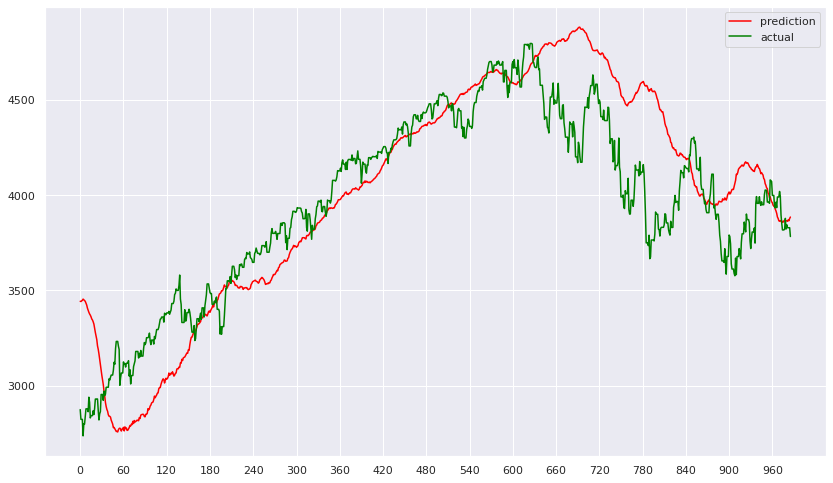

In [46]:
plt.plot(testPredict, label = "prediction",c='red')
plt.plot(testY, label = "actual",c='green')
plt.xticks(np.arange(0, len(testY), step=n_future))
plt.legend()
plt.show()